# LSTM

In [83]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_absolute_error, r2_score

In [84]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [85]:
torch.cuda.is_available()

True

In [86]:
device

device(type='cuda')

In [87]:
!nvidia-smi

Tue Oct 22 13:01:31 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   47C    P5              7W /   69W |    1533MiB /   8188MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Define DataSet

In [88]:

# Custom Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, data, target_col, input_cols, seq_length=4):
        self.data = data
        self.target_col = target_col
        self.input_cols = input_cols
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[self.input_cols].iloc[idx:idx+self.seq_length].values
        y = self.data[self.target_col].iloc[idx+self.seq_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Define the LSTM model

In [89]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        c_0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out

In [90]:
# df = pd.read_csv('../data_preprocessing/Merged_data/002_verwaltung.csv')
df = pd.read_csv('../data_preprocessing/Merged_data/002_verwaltung_hourly_with_holidays_indoor_person_counts.csv')

In [91]:
df.keys()

Index(['DateTime', 'electricity_hourly_diff', 'heating_hourly_diff',
       'is_holiday', 'day_of_week', 'hour_of_day', 'is_working_hour',
       'number_of_people', 'Temperature', 'Humidity', 'Dewpoint',
       'Sun Duration', 'Precipitation Height', 'Wind Speed', 'Wind Direction',
       'indoor_temperature', 'temperature_difference'],
      dtype='object')

In [92]:
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y-%m-%d %H:%M:%S')
df.set_index('DateTime', inplace=True)


In [93]:
df

,electricity_hourly_diff,heating_hourly_diff,is_holiday,day_of_week,hour_of_day,is_working_hour,number_of_people,Temperature,Humidity,Dewpoint,Sun Duration,Precipitation Height,Wind Speed,Wind Direction,indoor_temperature,temperature_difference
DateTime,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,0.0000,0.00,1.0,5.0,0.0,0.0,0.0,11.6,85.0,9.1,0.0,0.0,4.3,220.0,11.6,0.0
2022-01-01 01:00:00,5.0575,20.00,1.0,5.0,1.0,0.0,0.0,11.5,85.0,9.1,0.0,0.0,4.2,220.0,11.5,0.0
2022-01-01 02:00:00,4.9550,19.75,1.0,5.0,2.0,0.0,0.0,11.4,84.0,8.9,0.0,0.0,3.5,210.0,11.4,0.0
2022-01-01 03:00:00,5.0300,19.25,1.0,5.0,3.0,0.0,0.0,11.2,85.0,8.9,0.0,0.0,3.4,200.0,11.2,0.0
2022-01-01 04:00:00,6.3300,20.00,1.0,5.0,4.0,0.0,0.0,11.1,86.0,8.8,0.0,0.0,4.4,200.0,11.1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 20:00:00,8.9575,12.00,1.0,5.0,20.0,0.0,0.0,15.6,58.0,7.4,0.0,0.0,5.9,220.0,15.6,0.0
2022-12-31 21:00:00,7.5575,12.00,1.0,5.0,21.0,0.0,0.0,14.8,61.0,7.4,0.0,0.0,4.1,220.0,14.8,0.0
2022-12-31 22:00:00,7.1250,12.00,1.0,5.0,22.0,0.0,0.0,14.1,65.0,7.5,0.0,0.0,2.3,230.0,14.1,0.0


In [94]:
# Define the date ranges for training and test data
train_end_date = df.index.min() + pd.DateOffset(months=9)
test_start_date = train_end_date

# Split the DataFrame
train_data = df[:train_end_date]
test_data = df[test_start_date:]

# Task1: Predict the heating_15min_diff using the weather data

## using weather data as features

In [95]:
# Prepare the data
input_cols = [ 'Temperature',
       'Humidity', 'Dewpoint', 'Sun Duration', 'Precipitation Height',
       'Wind Speed', 'Wind Direction']
target_col = 'heating_hourly_diff'
seq_length = 4

train_dataset = TimeSeriesDataset(train_data, target_col, input_cols, seq_length)
test_dataset = TimeSeriesDataset(test_data, target_col, input_cols, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [96]:

input_size = len(input_cols)
hidden_size = 20
output_size = 1
num_layers = 1
model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

In [97]:
train_losses = []

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the same device as the model
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], avg_epoch_mse_loss:: {avg_epoch_loss:.4f}')



Epoch [1/100], avg_epoch_mse_loss:: 228.1427
Epoch [2/100], avg_epoch_mse_loss:: 169.0731
Epoch [3/100], avg_epoch_mse_loss:: 127.1863
Epoch [4/100], avg_epoch_mse_loss:: 89.8050
Epoch [5/100], avg_epoch_mse_loss:: 68.7804
Epoch [6/100], avg_epoch_mse_loss:: 53.7920
Epoch [7/100], avg_epoch_mse_loss:: 43.5437
Epoch [8/100], avg_epoch_mse_loss:: 36.3172
Epoch [9/100], avg_epoch_mse_loss:: 31.0972
Epoch [10/100], avg_epoch_mse_loss:: 28.3517
Epoch [11/100], avg_epoch_mse_loss:: 25.7273
Epoch [12/100], avg_epoch_mse_loss:: 23.5180
Epoch [13/100], avg_epoch_mse_loss:: 22.8296
Epoch [14/100], avg_epoch_mse_loss:: 21.7789
Epoch [15/100], avg_epoch_mse_loss:: 21.3152
Epoch [16/100], avg_epoch_mse_loss:: 20.5501
Epoch [17/100], avg_epoch_mse_loss:: 20.1744
Epoch [18/100], avg_epoch_mse_loss:: 19.6317
Epoch [19/100], avg_epoch_mse_loss:: 19.7079
Epoch [20/100], avg_epoch_mse_loss:: 18.9403
Epoch [21/100], avg_epoch_mse_loss:: 19.2058
Epoch [22/100], avg_epoch_mse_loss:: 19.1228
Epoch [23/100], 

In [98]:
# Evaluate the model
model.eval()
actuals = []
predictions = []
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the same device as the model
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        test_loss += loss.item()
        actuals.extend(targets.cpu().numpy())
        predictions.extend(outputs.cpu().numpy().flatten())
    print(f'Test  mse Loss: {test_loss/len(test_loader):.4f}')
    print(f'Test RSME Loss: {np.sqrt(test_loss/len(test_loader)):.4f}')
    
# Convert lists to numpy arrays for easier plotting
actuals = np.array(actuals)
predictions = np.array(predictions)

# Calculate MAE and R² score
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Test MAE: {mae:.4f}')
print(f'Test R² Score: {r2:.4f}')


Test  mse Loss: 62.4488
Test RSME Loss: 7.9025
Test MAE: 6.0659
Test R² Score: 0.1158


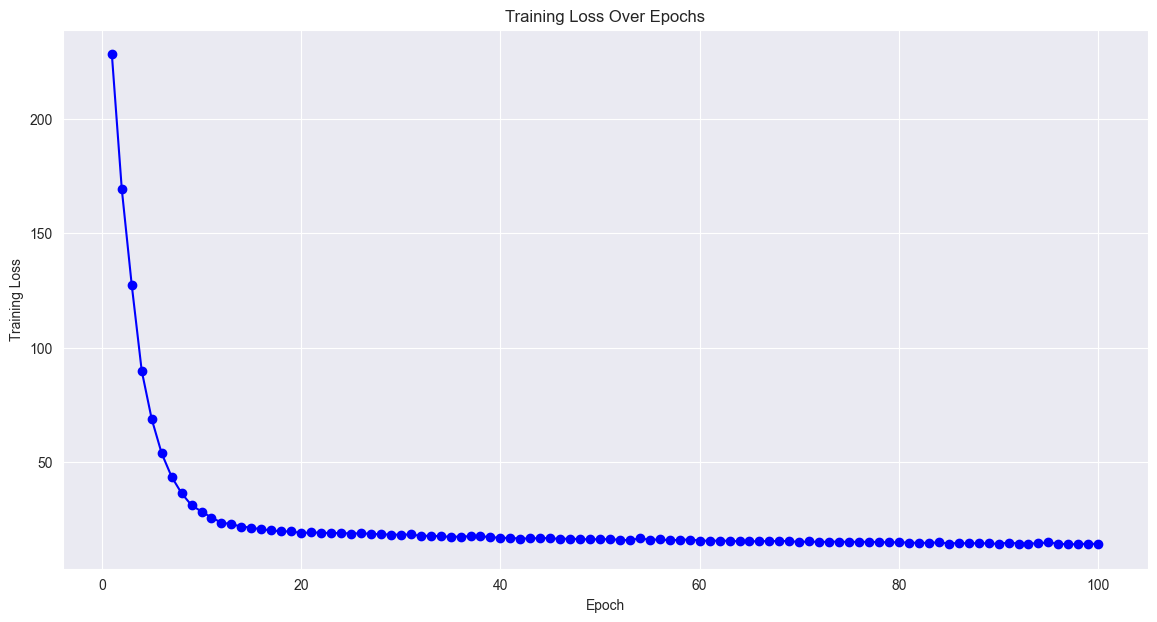

In [99]:
# Plot the training loss
plt.figure(figsize=(14, 7))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

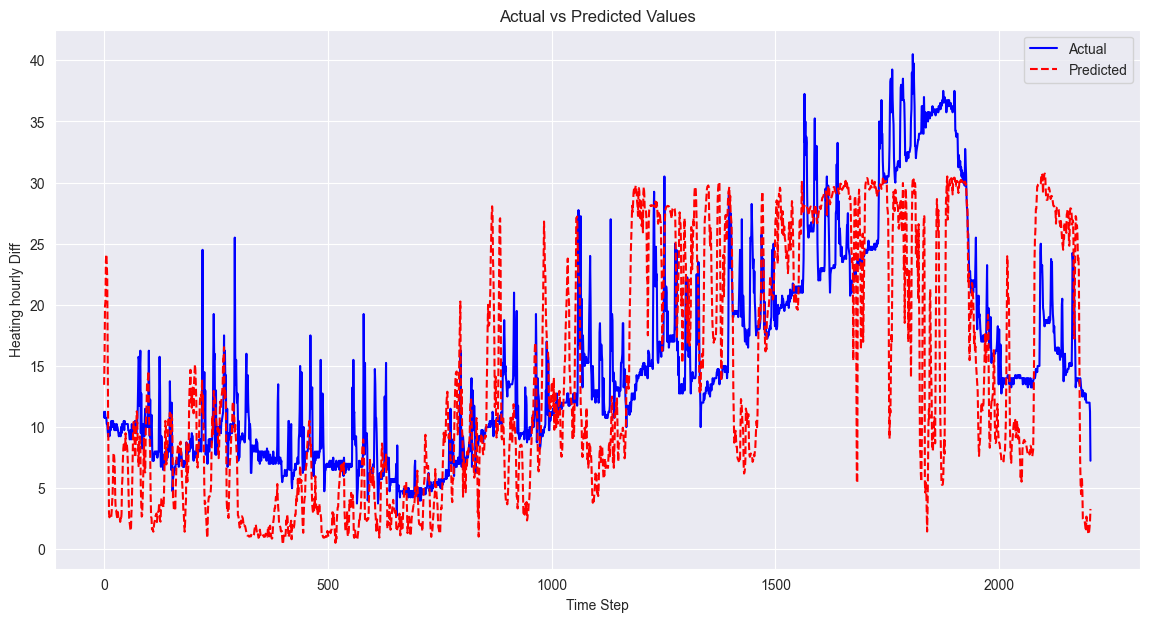

In [100]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(actuals, label='Actual', color='b')
plt.plot(predictions, label='Predicted', color='r', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Heating hourly Diff')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

# Using data with holidays

In [101]:
# df = pd.read_csv('../data_preprocessing/Merged_data/002_verwaltung_with_holidays.csv')

In [102]:
df = df.astype({'is_holiday': 'int32', 'day_of_week': 'int32', 'hour_of_day': 'int32', 'is_working_hour': 'int32'})

In [103]:
df

,electricity_hourly_diff,heating_hourly_diff,is_holiday,day_of_week,hour_of_day,is_working_hour,number_of_people,Temperature,Humidity,Dewpoint,Sun Duration,Precipitation Height,Wind Speed,Wind Direction,indoor_temperature,temperature_difference
DateTime,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,0.0000,0.00,1,5,0,0,0.0,11.6,85.0,9.1,0.0,0.0,4.3,220.0,11.6,0.0
2022-01-01 01:00:00,5.0575,20.00,1,5,1,0,0.0,11.5,85.0,9.1,0.0,0.0,4.2,220.0,11.5,0.0
2022-01-01 02:00:00,4.9550,19.75,1,5,2,0,0.0,11.4,84.0,8.9,0.0,0.0,3.5,210.0,11.4,0.0
2022-01-01 03:00:00,5.0300,19.25,1,5,3,0,0.0,11.2,85.0,8.9,0.0,0.0,3.4,200.0,11.2,0.0
2022-01-01 04:00:00,6.3300,20.00,1,5,4,0,0.0,11.1,86.0,8.8,0.0,0.0,4.4,200.0,11.1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 20:00:00,8.9575,12.00,1,5,20,0,0.0,15.6,58.0,7.4,0.0,0.0,5.9,220.0,15.6,0.0
2022-12-31 21:00:00,7.5575,12.00,1,5,21,0,0.0,14.8,61.0,7.4,0.0,0.0,4.1,220.0,14.8,0.0
2022-12-31 22:00:00,7.1250,12.00,1,5,22,0,0.0,14.1,65.0,7.5,0.0,0.0,2.3,230.0,14.1,0.0


In [104]:
df.keys()

Index(['electricity_hourly_diff', 'heating_hourly_diff', 'is_holiday',
       'day_of_week', 'hour_of_day', 'is_working_hour', 'number_of_people',
       'Temperature', 'Humidity', 'Dewpoint', 'Sun Duration',
       'Precipitation Height', 'Wind Speed', 'Wind Direction',
       'indoor_temperature', 'temperature_difference'],
      dtype='object')

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8761 entries, 2022-01-01 00:00:00 to 2023-01-01 00:00:00
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   electricity_hourly_diff  8761 non-null   float64
 1   heating_hourly_diff      8761 non-null   float64
 2   is_holiday               8761 non-null   int32  
 3   day_of_week              8761 non-null   int32  
 4   hour_of_day              8761 non-null   int32  
 5   is_working_hour          8761 non-null   int32  
 6   number_of_people         8761 non-null   float64
 7   Temperature              8761 non-null   float64
 8   Humidity                 8761 non-null   float64
 9   Dewpoint                 8761 non-null   float64
 10  Sun Duration             8761 non-null   float64
 11  Precipitation Height     8761 non-null   float64
 12  Wind Speed               8761 non-null   float64
 13  Wind Direction           8761 non-null   f

In [106]:
df.index.name

'DateTime'

In [107]:
# df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y-%m-%d %H:%M:%S')
# df.set_index('DateTime', inplace=True)

In [108]:

# Ensure all columns are numeric
df = df.apply(pd.to_numeric, errors='coerce')

In [109]:
# Drop rows with NaN values that may have been introduced by coercion
df.dropna(inplace=True)

In [110]:
# Define the date ranges for training and test data
# Define the date ranges for training and test data
train_end_date = df.index.min() + pd.DateOffset(months=9)
test_start_date = train_end_date

# Split the DataFrame
train_data = df[:train_end_date]
test_data = df[test_start_date:]

In [111]:
# Prepare the data
input_cols = [ 'is_holiday',
       'day_of_week', 'hour_of_day', 'is_working_hour', 'Temperature',
       'Humidity', 'Dewpoint', 'Sun Duration', 'Precipitation Height',
       'Wind Speed', 'Wind Direction']
target_col = 'heating_hourly_diff'# Prepare the data

seq_length = 4

train_dataset = TimeSeriesDataset(train_data, target_col, input_cols, seq_length)
test_dataset = TimeSeriesDataset(test_data, target_col, input_cols, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [112]:

input_size = len(input_cols)
hidden_size = 20
output_size = 1
num_layers = 1
model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

In [114]:
train_losses = []

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the same device as the model
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], avg_epoch_mse_loss:: {avg_epoch_loss:.4f}')


Epoch [1/100], avg_epoch_mse_loss:: 172.9866
Epoch [2/100], avg_epoch_mse_loss:: 130.3949
Epoch [3/100], avg_epoch_mse_loss:: 90.4217
Epoch [4/100], avg_epoch_mse_loss:: 64.2501
Epoch [5/100], avg_epoch_mse_loss:: 49.3099
Epoch [6/100], avg_epoch_mse_loss:: 39.5978
Epoch [7/100], avg_epoch_mse_loss:: 33.4709
Epoch [8/100], avg_epoch_mse_loss:: 29.2801
Epoch [9/100], avg_epoch_mse_loss:: 26.6827
Epoch [10/100], avg_epoch_mse_loss:: 24.3076
Epoch [11/100], avg_epoch_mse_loss:: 22.0557
Epoch [12/100], avg_epoch_mse_loss:: 21.2100
Epoch [13/100], avg_epoch_mse_loss:: 20.8051
Epoch [14/100], avg_epoch_mse_loss:: 20.0709
Epoch [15/100], avg_epoch_mse_loss:: 19.0250
Epoch [16/100], avg_epoch_mse_loss:: 18.8631
Epoch [17/100], avg_epoch_mse_loss:: 18.6797
Epoch [18/100], avg_epoch_mse_loss:: 18.6665
Epoch [19/100], avg_epoch_mse_loss:: 18.0135
Epoch [20/100], avg_epoch_mse_loss:: 17.7063
Epoch [21/100], avg_epoch_mse_loss:: 17.3178
Epoch [22/100], avg_epoch_mse_loss:: 16.7667
Epoch [23/100], a

In [115]:
# Evaluate the model
model.eval()
actuals = []
predictions = []
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        test_loss += loss.item()
        actuals.extend(targets.cpu().numpy())
        predictions.extend(outputs.cpu().numpy().flatten())
    print(f'Test mse Loss: {test_loss/len(test_loader):.4f}')
    print(f'Test RSME Loss: {np.sqrt(test_loss/len(test_loader)):.4f}')
    

# Convert lists to numpy arrays for easier plotting
actuals = np.array(actuals)
predictions = np.array(predictions)

# Calculate MAE and R² score
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Test MAE: {mae:.4f}')
print(f'Test R² Score: {r2:.4f}')


Test mse Loss: 52.5520
Test RSME Loss: 7.2493
Test MAE: 5.8936
Test R² Score: 0.2565


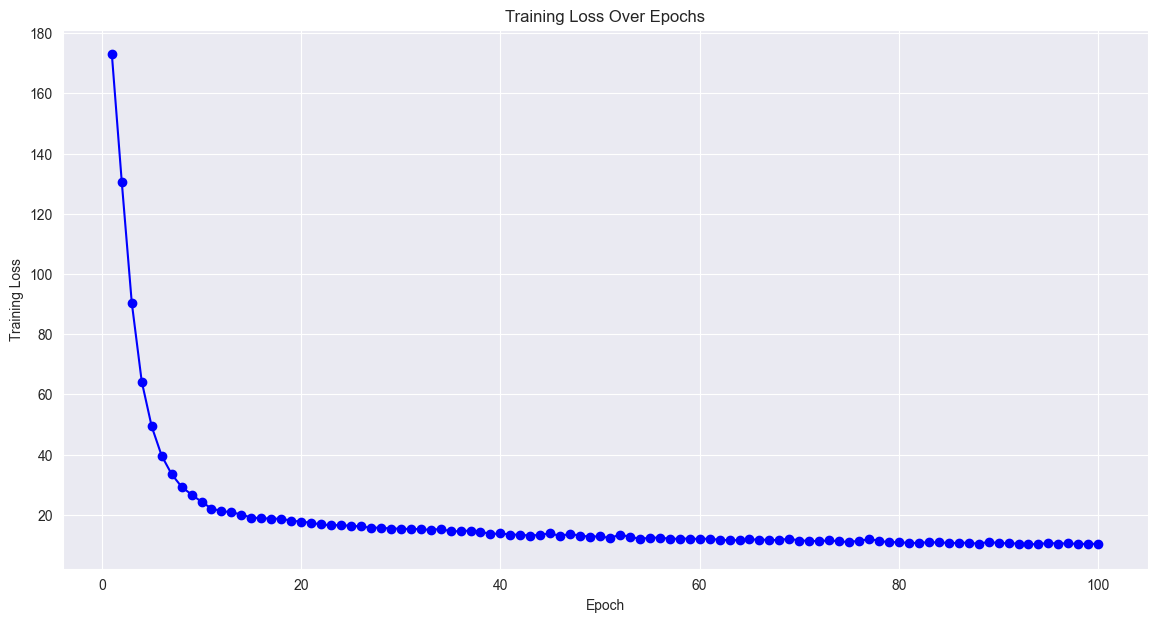

In [116]:
# Plot the training loss
plt.figure(figsize=(14, 7))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

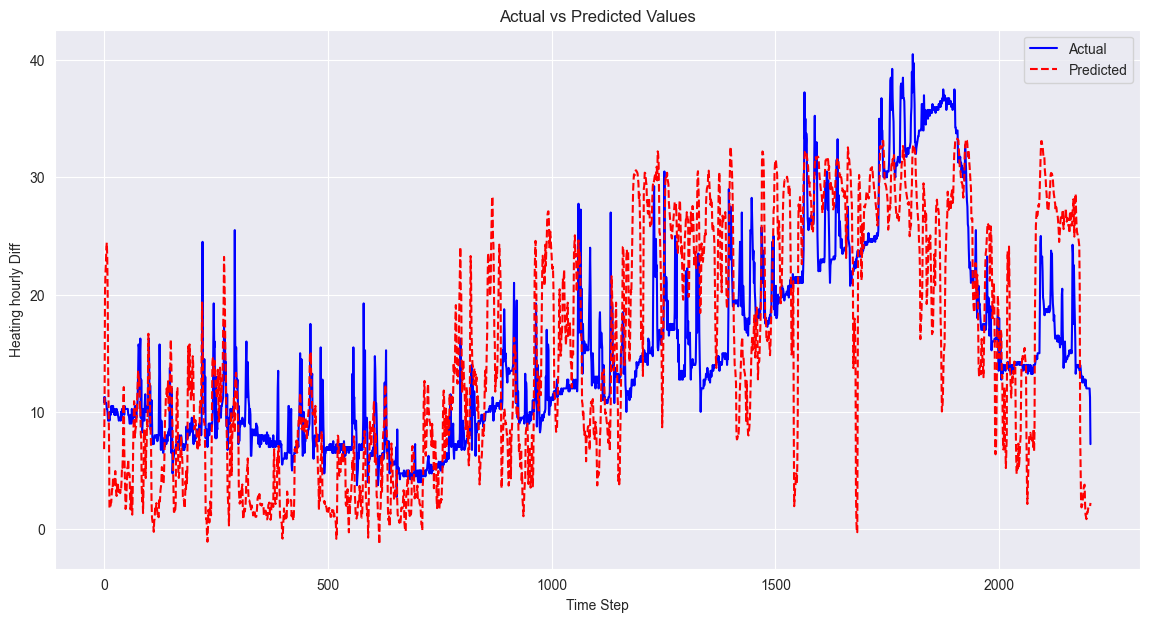

In [117]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(actuals, label='Actual', color='b')
plt.plot(predictions, label='Predicted', color='r', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Heating hourly Diff')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

## Using inddors features

In [118]:
# Prepare the data
input_cols = [  'is_holiday',
       'day_of_week', 'hour_of_day', 'is_working_hour', 'number_of_people',
       'Temperature', 'Humidity', 'Dewpoint', 'Sun Duration',
       'Precipitation Height', 'Wind Speed', 'Wind Direction',
       'indoor_temperature', 'temperature_difference']
target_col = 'heating_hourly_diff'# Prepare the data

seq_length = 4

train_dataset = TimeSeriesDataset(train_data, target_col, input_cols, seq_length)
test_dataset = TimeSeriesDataset(test_data, target_col, input_cols, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [119]:
input_size = len(input_cols)
hidden_size = 20
output_size = 1
num_layers = 1
model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

In [122]:
train_losses = []

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the same device as the model
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], avg_epoch_mse_loss:: {avg_epoch_loss:.4f}')


Epoch [1/100], avg_epoch_mse_loss:: 165.5633
Epoch [2/100], avg_epoch_mse_loss:: 120.2622
Epoch [3/100], avg_epoch_mse_loss:: 89.0306
Epoch [4/100], avg_epoch_mse_loss:: 67.7698
Epoch [5/100], avg_epoch_mse_loss:: 53.4430
Epoch [6/100], avg_epoch_mse_loss:: 42.6259
Epoch [7/100], avg_epoch_mse_loss:: 35.3297
Epoch [8/100], avg_epoch_mse_loss:: 30.1798
Epoch [9/100], avg_epoch_mse_loss:: 26.1772
Epoch [10/100], avg_epoch_mse_loss:: 24.1248
Epoch [11/100], avg_epoch_mse_loss:: 22.2206
Epoch [12/100], avg_epoch_mse_loss:: 20.9335
Epoch [13/100], avg_epoch_mse_loss:: 19.7825
Epoch [14/100], avg_epoch_mse_loss:: 19.2172
Epoch [15/100], avg_epoch_mse_loss:: 18.4459
Epoch [16/100], avg_epoch_mse_loss:: 17.8263
Epoch [17/100], avg_epoch_mse_loss:: 17.5499
Epoch [18/100], avg_epoch_mse_loss:: 17.2760
Epoch [19/100], avg_epoch_mse_loss:: 17.0658
Epoch [20/100], avg_epoch_mse_loss:: 17.0340
Epoch [21/100], avg_epoch_mse_loss:: 16.5601
Epoch [22/100], avg_epoch_mse_loss:: 16.5749
Epoch [23/100], a

In [123]:

# Evaluate the model
model.eval()
actuals = []
predictions = []
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        test_loss += loss.item()
        actuals.extend(targets.cpu().numpy())
        predictions.extend(outputs.cpu().numpy().flatten())
    print(f'Test  mse Loss: {test_loss/len(test_loader):.4f}')
    
    # Convert lists to numpy arrays for easier plotting
actuals = np.array(actuals)
predictions = np.array(predictions)

# Calculate MAE and R² score
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Test MAE: {mae:.4f}')
print(f'Test R² Score: {r2:.4f}')

Test  mse Loss: 43.9477
Test MAE: 5.3007
Test R² Score: 0.3781


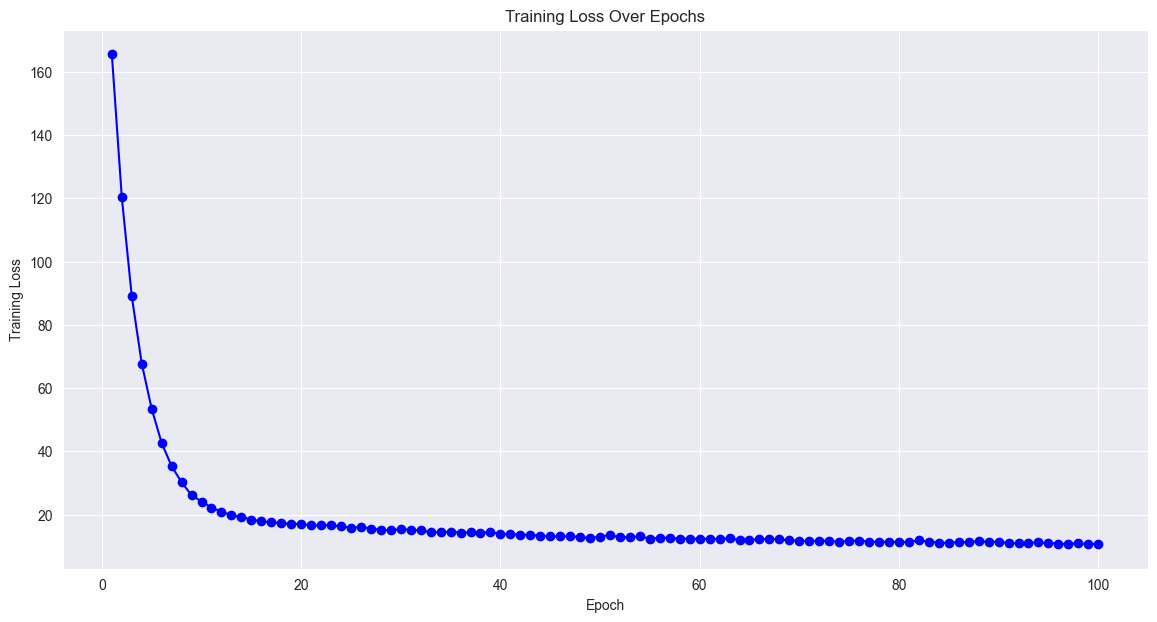

In [124]:
# Plot the training loss
plt.figure(figsize=(14, 7))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

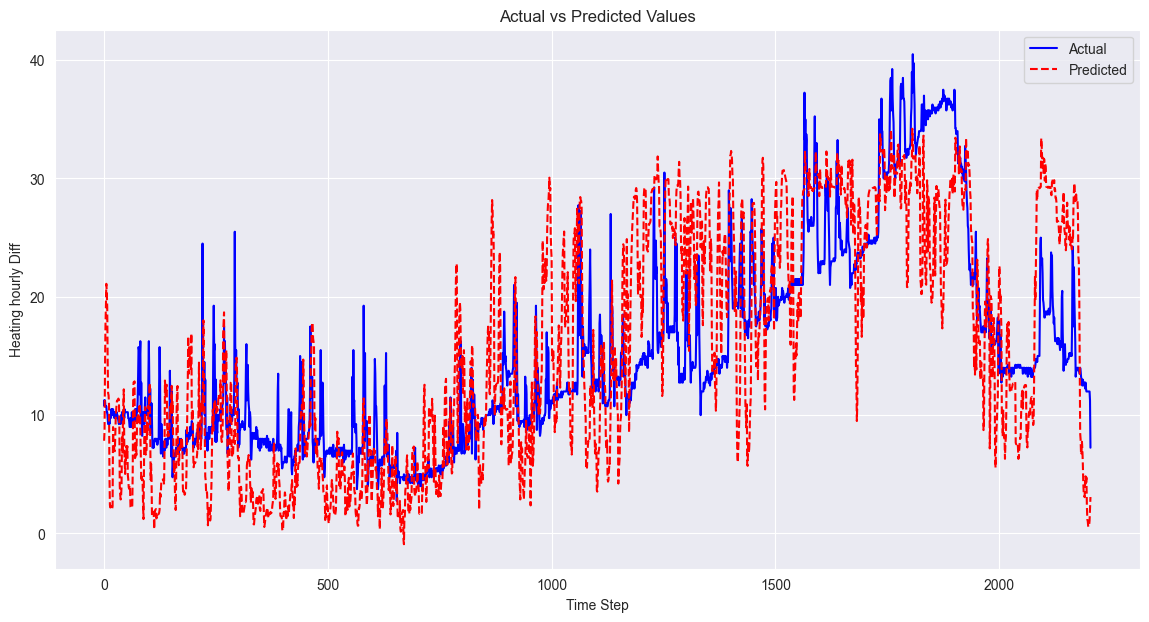

In [125]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(actuals, label='Actual', color='b')
plt.plot(predictions, label='Predicted', color='r', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Heating hourly Diff')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

# Task2: electricity_15min_diff

## using weather data as features

In [126]:
# Prepare the data
input_cols = [ 'Temperature',
       'Humidity', 'Dewpoint', 'Sun Duration', 'Precipitation Height',
       'Wind Speed', 'Wind Direction']
target_col = 'electricity_hourly_diff'
seq_length = 4

train_dataset = TimeSeriesDataset(train_data, target_col, input_cols, seq_length)
test_dataset = TimeSeriesDataset(test_data, target_col, input_cols, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [127]:

input_size = len(input_cols)
hidden_size = 20
output_size = 1
num_layers = 1
model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

In [130]:
train_losses = []

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the same device as the model
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], avg_epoch_mse_loss:: {avg_epoch_loss:.4f}')

Epoch [1/100], avg_epoch_mse_loss:: 37.3386
Epoch [2/100], avg_epoch_mse_loss:: 33.3043
Epoch [3/100], avg_epoch_mse_loss:: 32.4570
Epoch [4/100], avg_epoch_mse_loss:: 32.0732
Epoch [5/100], avg_epoch_mse_loss:: 31.8699
Epoch [6/100], avg_epoch_mse_loss:: 31.6410
Epoch [7/100], avg_epoch_mse_loss:: 31.5314
Epoch [8/100], avg_epoch_mse_loss:: 31.3364
Epoch [9/100], avg_epoch_mse_loss:: 31.1930
Epoch [10/100], avg_epoch_mse_loss:: 31.1016
Epoch [11/100], avg_epoch_mse_loss:: 31.0491
Epoch [12/100], avg_epoch_mse_loss:: 30.9668
Epoch [13/100], avg_epoch_mse_loss:: 30.8886
Epoch [14/100], avg_epoch_mse_loss:: 30.7655
Epoch [15/100], avg_epoch_mse_loss:: 30.7054
Epoch [16/100], avg_epoch_mse_loss:: 30.6128
Epoch [17/100], avg_epoch_mse_loss:: 30.5019
Epoch [18/100], avg_epoch_mse_loss:: 30.5238
Epoch [19/100], avg_epoch_mse_loss:: 30.3874
Epoch [20/100], avg_epoch_mse_loss:: 30.3596
Epoch [21/100], avg_epoch_mse_loss:: 30.3312
Epoch [22/100], avg_epoch_mse_loss:: 30.2804
Epoch [23/100], avg

In [131]:
# Evaluate the model
model.eval()
actuals = []
predictions = []
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        test_loss += loss.item()
        actuals.extend(targets.cpu().numpy())
        predictions.extend(outputs.cpu().numpy().flatten())
    print(f'Test mse Loss: {test_loss/len(test_loader):.4f}')
    print(f'Test RSME Loss: {np.sqrt(test_loss/len(test_loader)):.4f}')
    

# Convert lists to numpy arrays for easier plotting
actuals = np.array(actuals)
predictions = np.array(predictions)

# Calculate MAE and R² score
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Test MAE: {mae:.4f}')
print(f'Test R² Score: {r2:.4f}')

Test mse Loss: 15.8265
Test RSME Loss: 3.9783
Test MAE: 2.9490
Test R² Score: -0.0574


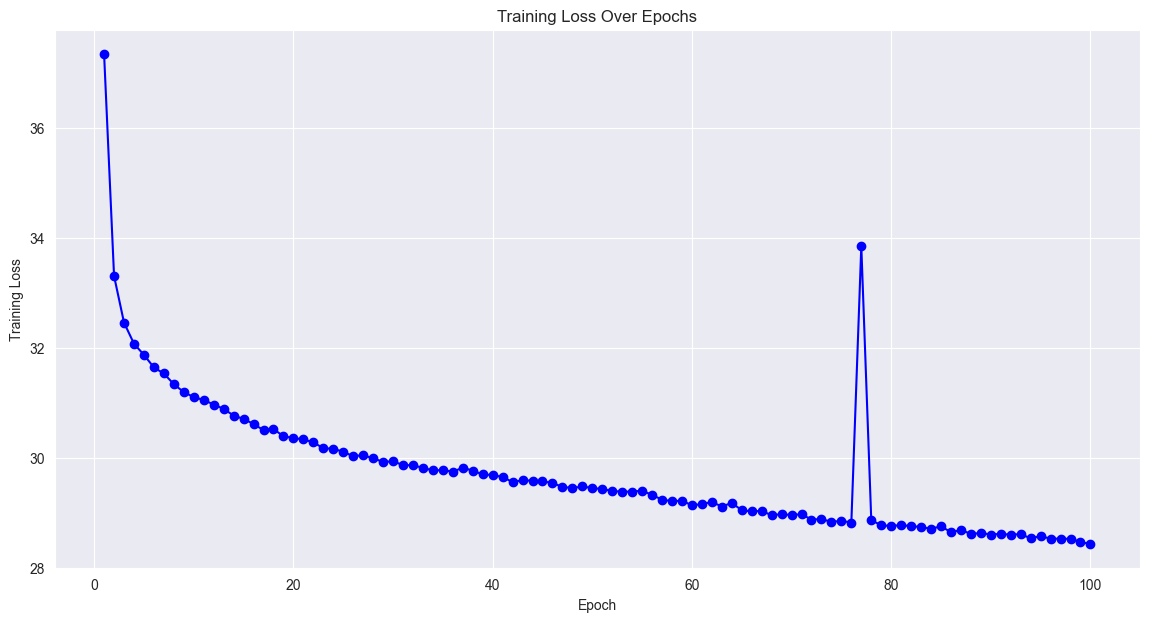

In [132]:
# Plot the training loss
plt.figure(figsize=(14, 7))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

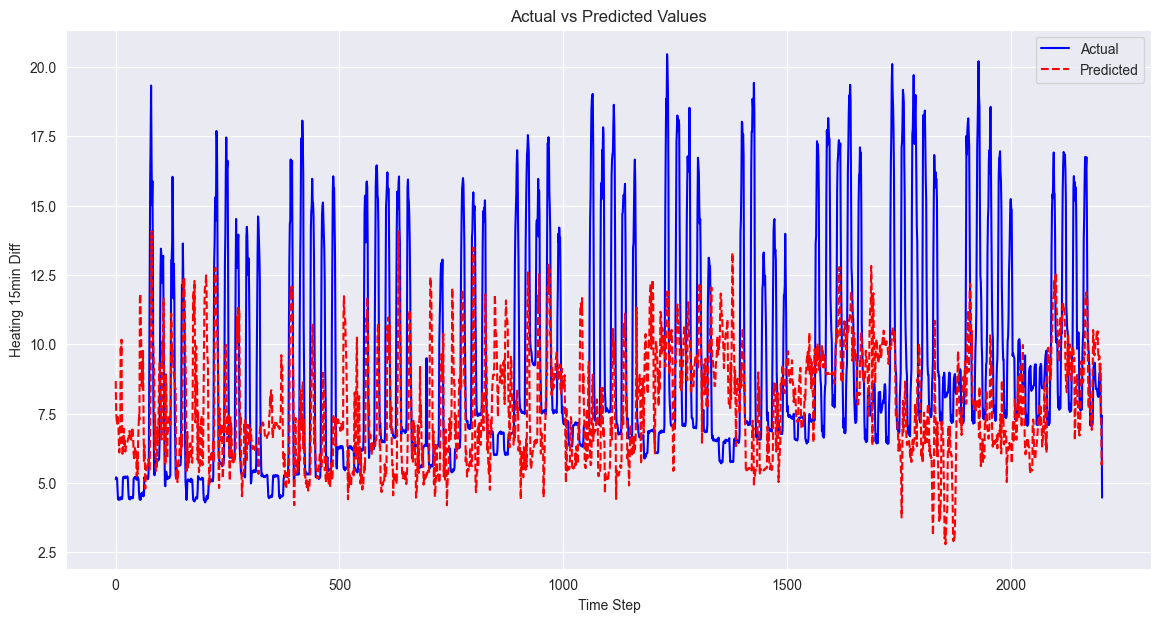

In [133]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(actuals, label='Actual', color='b')
plt.plot(predictions, label='Predicted', color='r', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Heating 15min Diff')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

## Using data with holidays

In [134]:
# Prepare the data
input_cols = [ 'is_holiday',
       'day_of_week', 'hour_of_day', 'is_working_hour', 'Temperature',
       'Humidity', 'Dewpoint', 'Sun Duration', 'Precipitation Height',
       'Wind Speed', 'Wind Direction']
target_col = 'electricity_hourly_diff'# Prepare the data

seq_length = 4

train_dataset = TimeSeriesDataset(train_data, target_col, input_cols, seq_length)
test_dataset = TimeSeriesDataset(test_data, target_col, input_cols, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [135]:

input_size = len(input_cols)
hidden_size = 20
output_size = 1
num_layers = 1
model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

In [138]:
train_losses = []

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the same device as the model
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], avg_epoch_mse_loss:: {avg_epoch_loss:.4f}')

Epoch [1/100], avg_epoch_mse_loss:: 35.9029
Epoch [2/100], avg_epoch_mse_loss:: 31.5253
Epoch [3/100], avg_epoch_mse_loss:: 29.4959
Epoch [4/100], avg_epoch_mse_loss:: 27.4663
Epoch [5/100], avg_epoch_mse_loss:: 26.3300
Epoch [6/100], avg_epoch_mse_loss:: 25.1515
Epoch [7/100], avg_epoch_mse_loss:: 24.4870
Epoch [8/100], avg_epoch_mse_loss:: 24.2015
Epoch [9/100], avg_epoch_mse_loss:: 23.8635
Epoch [10/100], avg_epoch_mse_loss:: 23.4619
Epoch [11/100], avg_epoch_mse_loss:: 23.2192
Epoch [12/100], avg_epoch_mse_loss:: 23.0520
Epoch [13/100], avg_epoch_mse_loss:: 22.9132
Epoch [14/100], avg_epoch_mse_loss:: 23.0151
Epoch [15/100], avg_epoch_mse_loss:: 22.8061
Epoch [16/100], avg_epoch_mse_loss:: 22.7449
Epoch [17/100], avg_epoch_mse_loss:: 22.4495
Epoch [18/100], avg_epoch_mse_loss:: 22.5402
Epoch [19/100], avg_epoch_mse_loss:: 22.2367
Epoch [20/100], avg_epoch_mse_loss:: 22.4930
Epoch [21/100], avg_epoch_mse_loss:: 22.3502
Epoch [22/100], avg_epoch_mse_loss:: 22.2554
Epoch [23/100], avg

In [139]:
# Evaluate the model
model.eval()
actuals = []
predictions = []
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        test_loss += loss.item()
        actuals.extend(targets.cpu().numpy())
        predictions.extend(outputs.cpu().numpy().flatten())
    print(f'Test mse Loss: {test_loss/len(test_loader):.4f}')
    print(f'Test RSME Loss: {np.sqrt(test_loss/len(test_loader)):.4f}')
    

# Convert lists to numpy arrays for easier plotting
actuals = np.array(actuals)
predictions = np.array(predictions)

# Calculate MAE and R² score
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Test MAE: {mae:.4f}')
print(f'Test R² Score: {r2:.4f}')

Test mse Loss: 4.5597
Test RSME Loss: 2.1354
Test MAE: 1.5986
Test R² Score: 0.6958


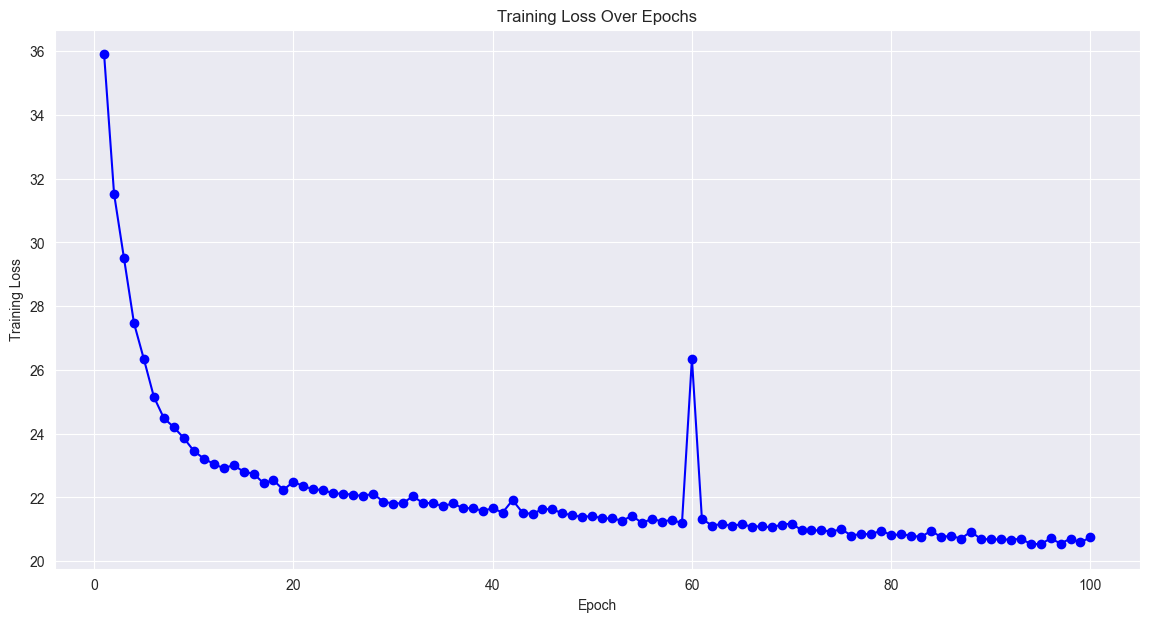

In [140]:
# Plot the training loss
plt.figure(figsize=(14, 7))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

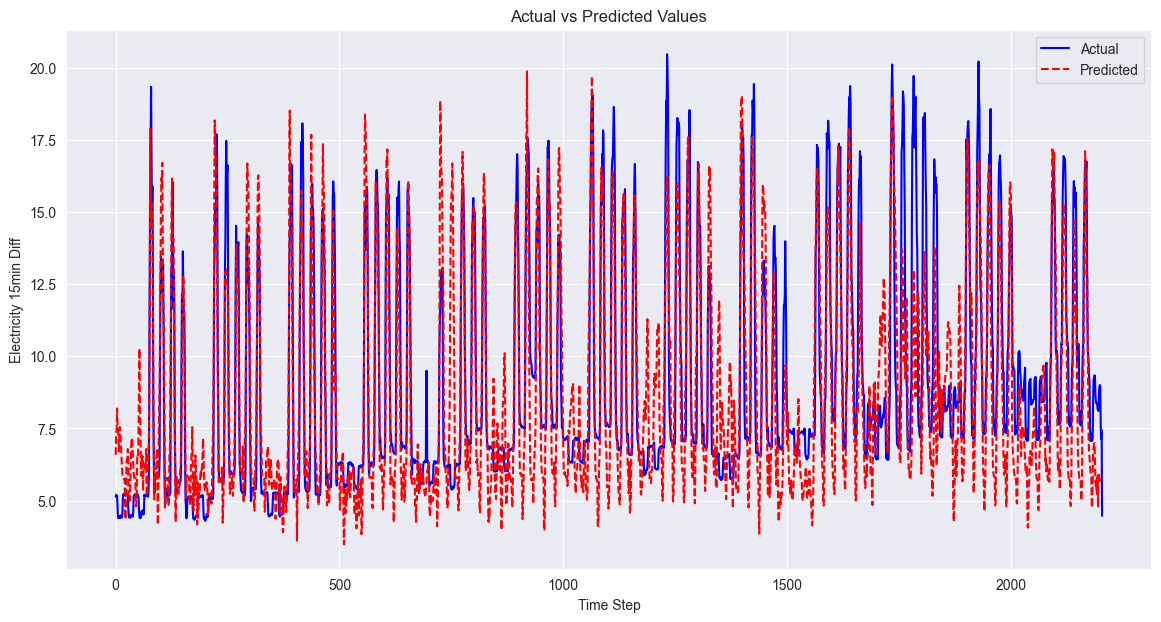

In [141]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(actuals, label='Actual', color='b')
plt.plot(predictions, label='Predicted', color='r', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Electricity 15min Diff')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

## Using inddors features

In [142]:
# Prepare the data
input_cols = [  'is_holiday',
       'day_of_week', 'hour_of_day', 'is_working_hour', 'number_of_people',
       'Temperature', 'Humidity', 'Dewpoint', 'Sun Duration',
       'Precipitation Height', 'Wind Speed', 'Wind Direction',
       'indoor_temperature', 'temperature_difference']
target_col = 'electricity_hourly_diff'# Prepare the data

seq_length = 4

train_dataset = TimeSeriesDataset(train_data, target_col, input_cols, seq_length)
test_dataset = TimeSeriesDataset(test_data, target_col, input_cols, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [143]:
input_size = len(input_cols)
hidden_size = 20
output_size = 1
num_layers = 1
model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

In [146]:
train_losses = []

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the same device as the model
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], avg_epoch_mse_loss:: {avg_epoch_loss:.4f}')

Epoch [1/100], avg_epoch_mse_loss:: 35.5929
Epoch [2/100], avg_epoch_mse_loss:: 30.4188
Epoch [3/100], avg_epoch_mse_loss:: 28.3659
Epoch [4/100], avg_epoch_mse_loss:: 27.3071
Epoch [5/100], avg_epoch_mse_loss:: 26.6340
Epoch [6/100], avg_epoch_mse_loss:: 26.1681
Epoch [7/100], avg_epoch_mse_loss:: 25.8921
Epoch [8/100], avg_epoch_mse_loss:: 25.5276
Epoch [9/100], avg_epoch_mse_loss:: 25.0906
Epoch [10/100], avg_epoch_mse_loss:: 24.9753
Epoch [11/100], avg_epoch_mse_loss:: 24.8511
Epoch [12/100], avg_epoch_mse_loss:: 24.6265
Epoch [13/100], avg_epoch_mse_loss:: 24.5211
Epoch [14/100], avg_epoch_mse_loss:: 24.3501
Epoch [15/100], avg_epoch_mse_loss:: 24.3728
Epoch [16/100], avg_epoch_mse_loss:: 24.4919
Epoch [17/100], avg_epoch_mse_loss:: 24.2996
Epoch [18/100], avg_epoch_mse_loss:: 23.9817
Epoch [19/100], avg_epoch_mse_loss:: 23.8381
Epoch [20/100], avg_epoch_mse_loss:: 23.6334
Epoch [21/100], avg_epoch_mse_loss:: 23.5354
Epoch [22/100], avg_epoch_mse_loss:: 23.4547
Epoch [23/100], avg

In [147]:
# Evaluate the model
model.eval()
actuals = []
predictions = []
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        test_loss += loss.item()
        actuals.extend(targets.cpu().numpy())
        predictions.extend(outputs.cpu().numpy().flatten())
    print(f'Test mse Loss: {test_loss/len(test_loader):.4f}')
    print(f'Test RSME Loss: {np.sqrt(test_loss/len(test_loader)):.4f}')
    

# Convert lists to numpy arrays for easier plotting
actuals = np.array(actuals)
predictions = np.array(predictions)

# Calculate MAE and R² score
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Test MAE: {mae:.4f}')
print(f'Test R² Score: {r2:.4f}')

Test mse Loss: 4.5962
Test RSME Loss: 2.1439
Test MAE: 1.6363
Test R² Score: 0.6940


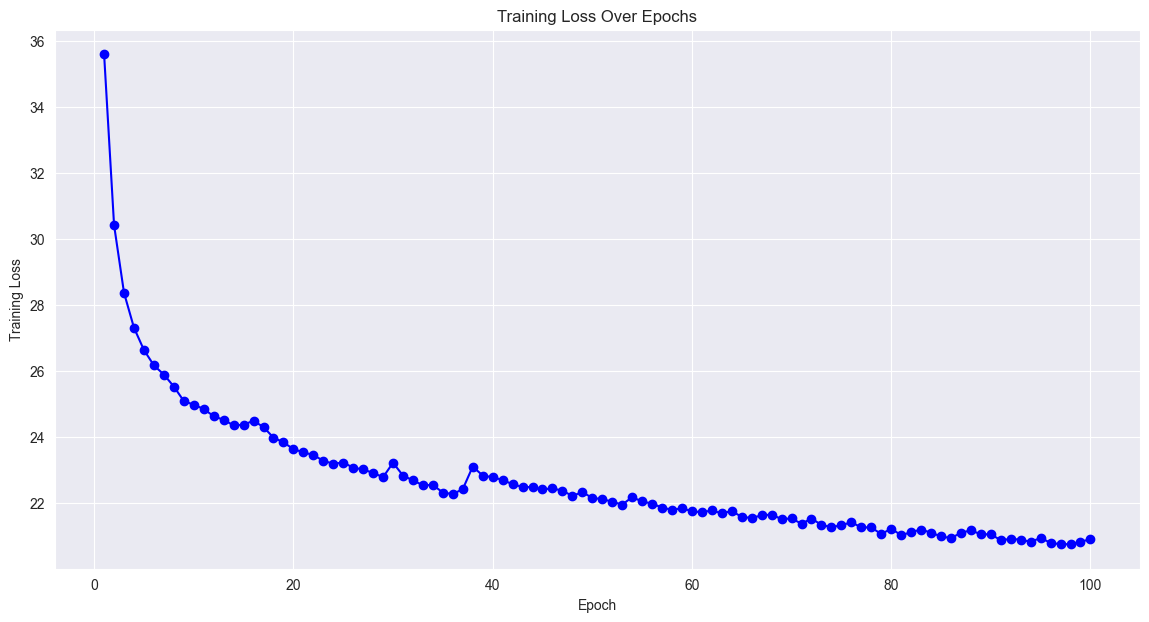

In [148]:
# Plot the training loss
plt.figure(figsize=(14, 7))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

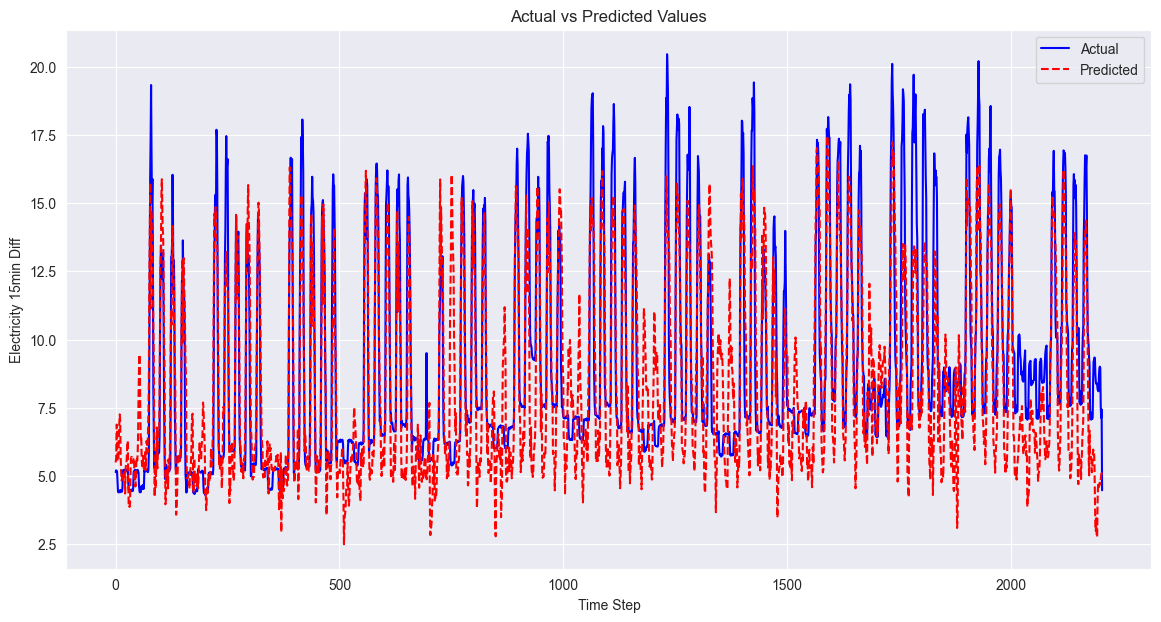

In [149]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(actuals, label='Actual', color='b')
plt.plot(predictions, label='Predicted', color='r', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Electricity 15min Diff')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()